#Function Definitions

In [ ]:
def download_and_extract_zip(file_id, target_folder_name):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the URL for the file
    url = f'https://drive.google.com/uc?id={file_id}'

    # Define the path for the downloaded ZIP file
    zip_file_path = f'/content/{target_folder_name}.zip'

    # Download the ZIP file
    gdown.download(url, zip_file_path, quiet=False)

    # Define temporary extraction directory
    temp_extract_dir = '/content/temp_extract/'

    # Define the target directory
    extract_dir = f'/content/{target_folder_name}/'

    # Create the target directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Create the temporary extraction directory
    os.makedirs(temp_extract_dir, exist_ok=True)

    # Unzip the file to the temporary directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)

    # Move the contents of the temporary directory to the target directory
    for item in os.listdir(temp_extract_dir):
        s = os.path.join(temp_extract_dir, item)
        d = os.path.join(extract_dir, item)
        if os.path.isdir(s):
            shutil.move(s, d)
        else:
            shutil.move(s, d)

    # Remove the temporary directory
    shutil.rmtree(temp_extract_dir)

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_file_path)

    # Return the path to the extracted directory
    return extract_dir

In [ ]:
def delete_folder(folder_path):
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Delete the folder and its contents
        shutil.rmtree(folder_path)

In [ ]:
def extract_number(filename):
    # Extract numerical part from filename
    return int(filename.stem.split('_')[-1])

In [ ]:
def preprocess(image, label, num_classes):
  # One-hot encode the labels
  label = tf.one_hot(label, depth=num_classes)
  return image, label

#Imports

In [ ]:
import os
import pathlib
import shutil
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2

from google.colab import drive


#Download and Extract Images

In [ ]:
file_id = '1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI'
target_folder_name = 'Automating_Port_Operations_dataset'

In [ ]:
download_dir = download_and_extract_zip(file_id, target_folder_name)

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI
From (redirected): https://drive.google.com/uc?id=1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI&confirm=t&uuid=518ccddf-c4a4-4f1f-904c-9cebd9e6647a
To: /content/Automating_Port_Operations_dataset.zip
100%|██████████| 150M/150M [00:04<00:00, 33.6MB/s]


In [ ]:
data_dir = pathlib.Path(download_dir + '//' + target_folder_name + '//')
data_dir

PosixPath('/content/Automating_Port_Operations_dataset/Automating_Port_Operations_dataset')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1162


# 2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

**2.1.	Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.**

**2.2 Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.**

**2.3 Load train, validation and test dataset in batches of 32 using the function initialized in the above step.**

In [ ]:
batch_size = 32 # for training we will pass images in batches of 32 to the model
img_height = 180 # standardizing the height and width of the images
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,  # 30% for validation/test combined
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 814 files for training.


In [ ]:
# Keep the temp_ds creation as is (50% of the remaining 30%)
temp_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 581 files for validation.


In [ ]:
# The val_ds and test_ds splitting remains the same,
# effectively giving you a 70/15/15 split:
val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

In [ ]:
print("Training set size:", len(train_ds))
print("Validation set size:", len(val_ds))
print("Test set size:", len(test_ds))

Training set size: 26
Validation set size: 9
Test set size: 10


In [ ]:
# get the class label names before applying map for image rescale
class_names = train_ds.class_names
print(class_names)

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


In [ ]:
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
print(class_indices)

{'buoy': 0, 'cruise_ship': 1, 'ferry_boat': 2, 'freight_boat': 3, 'gondola': 4, 'inflatable_boat': 5, 'kayak': 6, 'paper_boat': 7, 'sailboat': 8}


In [ ]:
for images, labels in train_ds.take(1):  # Take one batch
    print(images.shape)

(32, 180, 180, 3)


**2.4 Build a CNN network using Keras with the following layers**

* Load MobileNetV2 - Light Model as the first layer
(Hint: Keras API Doc)
* GLobalAveragePooling2D layer
* Dropout(0.2)
* Dense layer with 256 neurons and activation relu
* BatchNormalization layer
* Dropout(0.1)
* Dense layer with 128 neurons and activation relu
* BatchNormalization layer
* Dropout(0.1)
* Dense layer with 9 neurons and activation softmax





In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # optimize for performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

In [ ]:
num_classes

9

In [ ]:
normalization_layer = layers.Rescaling(1./255)

# Apply Rescaling to normalize pixel values
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # checking the min and max pixel values in the batch

0.0 1.0


In [ ]:
num_classes = len(class_names)

# Define the base model and freeze its layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

# Define the model inputs
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Apply the base model and subsequent layers
x = base_model(inputs, training=False)  # Ensure the base model layers are not trained
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)


<ipython-input-27-c6a839a2836e>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

**1.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.**

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

**1.6.	Train the model for 20 epochs and plot training loss and accuracy against epochs.**

In [ ]:
epochs=50 # we will train model for 50 epochs

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3955 - loss: 2.0044 - precision: 0.5568 - recall: 0.2853 - val_accuracy: 0.7569 - val_loss: 0.8546 - val_precision: 0.8000 - val_recall: 0.7222
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8288 - loss: 0.5462 - precision: 0.8800 - recall: 0.7637 - val_accuracy: 0.8576 - val_loss: 0.5478 - val_precision: 0.8876 - val_recall: 0.8229
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9207 - loss: 0.2803 - precision: 0.9510 - recall: 0.8895 - val_accuracy: 0.8611 - val_loss: 0.5013 - val_precision: 0.8963 - val_recall: 0.8403
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9420 - loss: 0.2074 - precision: 0.9621 - recall: 0.9135 - val_accuracy: 0.8958 - val_loss: 0.4632 - val_precision: 0.9191 - val_recall: 0.8681
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9861 - loss: 0.1160 - precision: 0.9858 - recall: 0.9599 - val_accuracy: 0.9097 - val_loss: 0.4263 - val

**1.7.	Evaluate the model on test images and print the test loss and accuracy.**

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 719ms/step - accuracy: 0.8495 - loss: 0.8171 - precision: 0.8513 - recall: 0.8485
Test loss: 0.8294490575790405
Test accuracy: 0.8566552996635437
Test precision: 0.8620689511299133
Test recall: 0.8532423377037048


**1.8.	Plot heatmap of the confusion matrix and print classification report.**

In [ ]:
# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 984ms/step


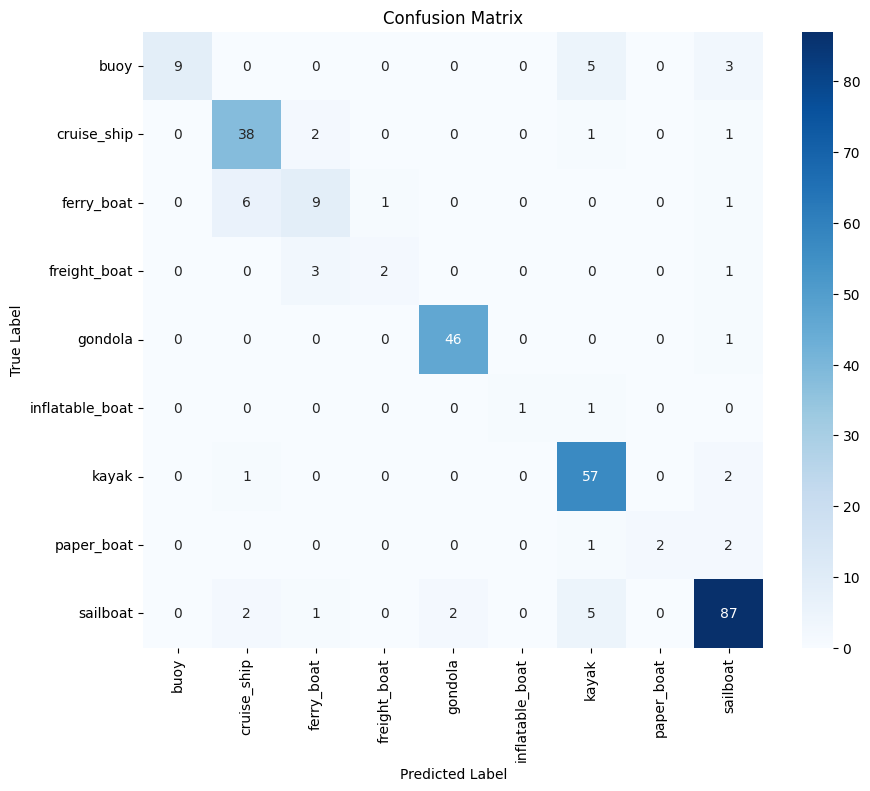

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Perform Prediction on Random file selected from dataset source


In [ ]:
os.listdir(data_dir)

                 precision    recall  f1-score   support

           buoy       1.00      0.53      0.69        17
    cruise_ship       0.81      0.90      0.85        42
     ferry_boat       0.60      0.53      0.56        17
   freight_boat       0.67      0.33      0.44         6
        gondola       0.96      0.98      0.97        47
inflatable_boat       1.00      0.50      0.67         2
          kayak       0.81      0.95      0.88        60
     paper_boat       1.00      0.40      0.57         5
       sailboat       0.89      0.90      0.89        97

       accuracy                           0.86       293
      macro avg       0.86      0.67      0.73       293
   weighted avg       0.86      0.86      0.85       293



['inflatable_boat',
 'buoy',
 'cruise_ship',
 'ferry_boat',
 'paper_boat',
 'sailboat',
 'gondola',
 'freight_boat',
 'kayak']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image Path: /content/Automating_Port_Operations_dataset/Automating_Port_Operations_dataset/buoy/11.jpg
Image Filename: 11.jpg
Predictions: [[2.5781950e-01 1.0377640e-04 3.3735042e-03 8.2050534e-03 3.5797790e-04
  4.9593709e-03 2.3540039e-01 4.8632905e-01 3.4514023e-03]]


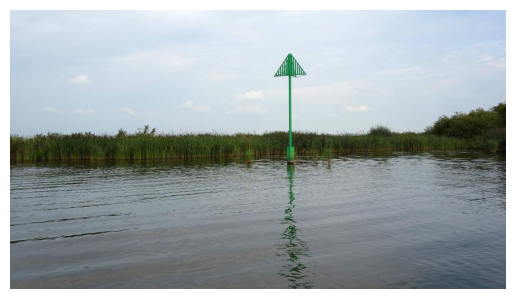

In [ ]:
# Get a list of all subdirectories in the data directory
subdirectories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

if subdirectories:
    # Choose a random subdirectory
    random_subdir = random.choice(subdirectories)

    # Construct the path to the random subdirectory
    random_subdir_path = os.path.join(data_dir, random_subdir)

    # Get a list of all image files in the random subdirectory
    image_files = [f for f in os.listdir(random_subdir_path) if os.path.isfile(os.path.join(random_subdir_path, f))]

    if image_files:
        # Choose a random image file
        random_image_file = random.choice(image_files)

        # Construct the full path to the random image
        random_image_path = os.path.join(random_subdir_path, random_image_file)

        # Load and predict
        img = tf.keras.utils.load_img(
            random_image_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)

        # Print predictions along with image path and filename
        print(f"Image Path: {random_image_path}")
        print(f"Image Filename: {random_image_file}")
        print("Predictions:", predictions)

        # Display the image
        img = mpimg.imread(random_image_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

    else:
        print(f"No image files found in the subdirectory: {random_subdir}")

else:
    print("No subdirectories found in the data directory.")

#Cleanup

In [ ]:
delete_folder(target_folder_name)